Wyniki walidacji (2023): R2=0.960, MAE=42781


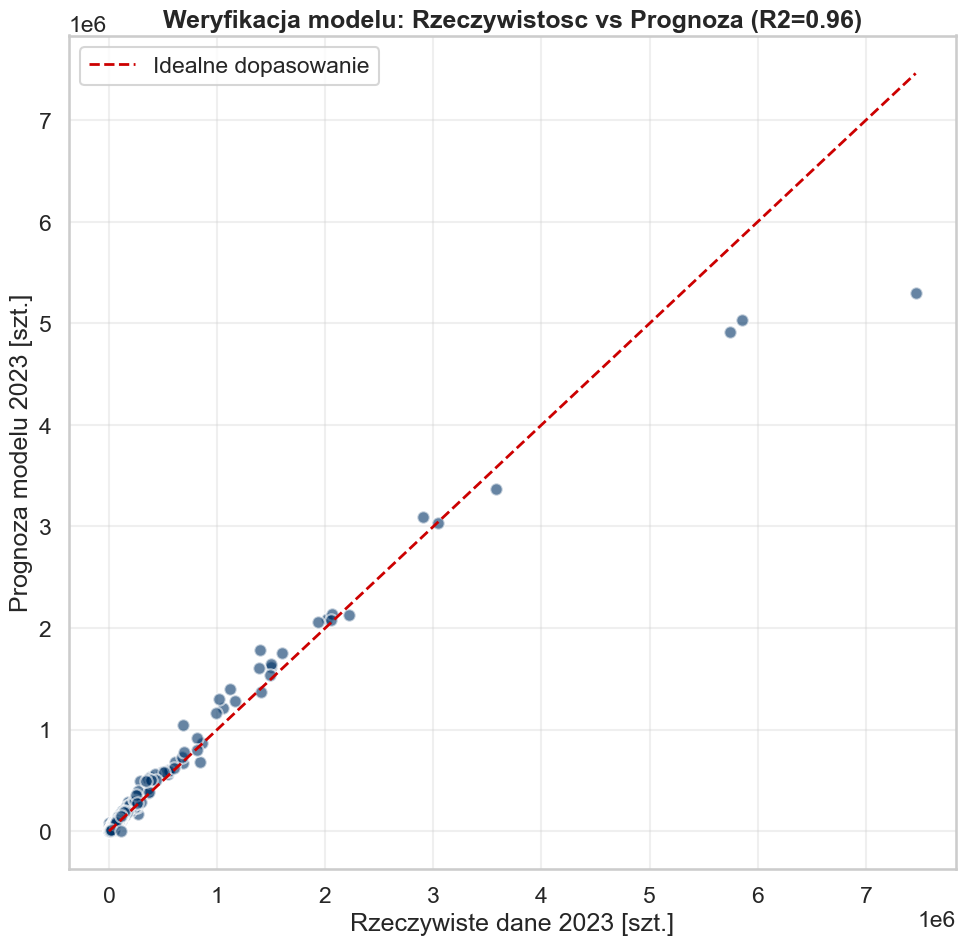

Zapisano plik: Prognoza_Powiaty_2024.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import os

# Styl wykresow
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'Arial'

# 1. Wczytanie danych
file_name = "master_dataset_project.csv"

if os.path.exists(file_name):
    df = pd.read_csv(file_name)
elif os.path.exists(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv"):
    df = pd.read_csv(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv")
else:
    raise FileNotFoundError("Nie znaleziono pliku master_dataset_project.csv")

# Czyszczenie
df.columns = df.columns.str.strip()
df['Rok'] = pd.to_numeric(df['Rok'], errors='coerce')
df = df.dropna(subset=['Rok'])
df['Rok'] = df['Rok'].astype(int)

# 2. Inzynieria cech (Feature Engineering)
# Sortowanie do tworzenia zmiennych opoznionych
df = df.sort_values(by=['Kod', 'Rok'])

# Lag (rok poprzedni)
df['Noclegi_LastYear'] = df.groupby('Kod')['Udzielone_Noclegi'].shift(1)
df = df.dropna(subset=['Noclegi_LastYear'])

# Wybor zmiennych
features = ['Rok', 'Liczba_Miejsc', 'Gestosc_Zaludnienia', 'Lesistosc_Proc', 'Noclegi_LastYear']
target = 'Udzielone_Noclegi'

# 3. Walidacja (Backtesting na roku 2023)
train = df[df['Rok'] < 2023].copy()
test = df[df['Rok'] == 2023].copy()

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(train[features], train[target])

# Predykcja testowa
preds_2023 = model.predict(test[features])

# Wyniki walidacji
r2 = r2_score(test[target], preds_2023)
mae = mean_absolute_error(test[target], preds_2023)
print(f"Wyniki walidacji (2023): R2={r2:.3f}, MAE={mae:.0f}")

# Wykres walidacyjny
plt.figure(figsize=(10, 10))
plt.scatter(test[target], preds_2023, alpha=0.6, color='#003366', edgecolors='w', s=80)

# Linia idealna (y=x)
max_val = max(test[target].max(), preds_2023.max())
plt.plot([0, max_val], [0, max_val], '--', color='#cc0000', linewidth=2, label='Idealne dopasowanie')

plt.xlabel('Rzeczywiste dane 2023 [szt.]')
plt.ylabel('Prognoza modelu 2023 [szt.]')
plt.title(f'Weryfikacja modelu: Rzeczywistosc vs Prognoza (R2={r2:.2f})', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Walidacja_Modelu.png", dpi=300)
plt.show()

# 4. Prognoza na 2024
# Trenujemy model na pelnych danych (do 2023)
full_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
full_model.fit(df[features], df[target])

# Dane wejsciowe na 2024 (bazujemy na 2023)
future = df[df['Rok'] == 2023].copy()
future['Rok'] = 2024
future['Noclegi_LastYear'] = future['Udzielone_Noclegi'] # Historia to 2023

# Predykcja
future['Prognoza_2024'] = full_model.predict(future[features]).astype(int)

# 5. Eksport wynikow
results = future[['Kod', 'Nazwa', 'Udzielone_Noclegi', 'Prognoza_2024']].copy()
results.rename(columns={'Udzielone_Noclegi': 'Rzeczywiste_2023'}, inplace=True)

# Obliczenie dynamiki
results['Zmiana_Proc'] = ((results['Prognoza_2024'] - results['Rzeczywiste_2023']) / results['Rzeczywiste_2023'] * 100).round(2)
results['Status'] = np.where(results['Zmiana_Proc'] > 0, 'Wzrost', 'Spadek')

# Zapis do CSV
results.to_csv("Prognoza_Powiaty_2024.csv", index=False, sep=';', encoding='utf-8-sig')
print("Zapisano plik: Prognoza_Powiaty_2024.csv")

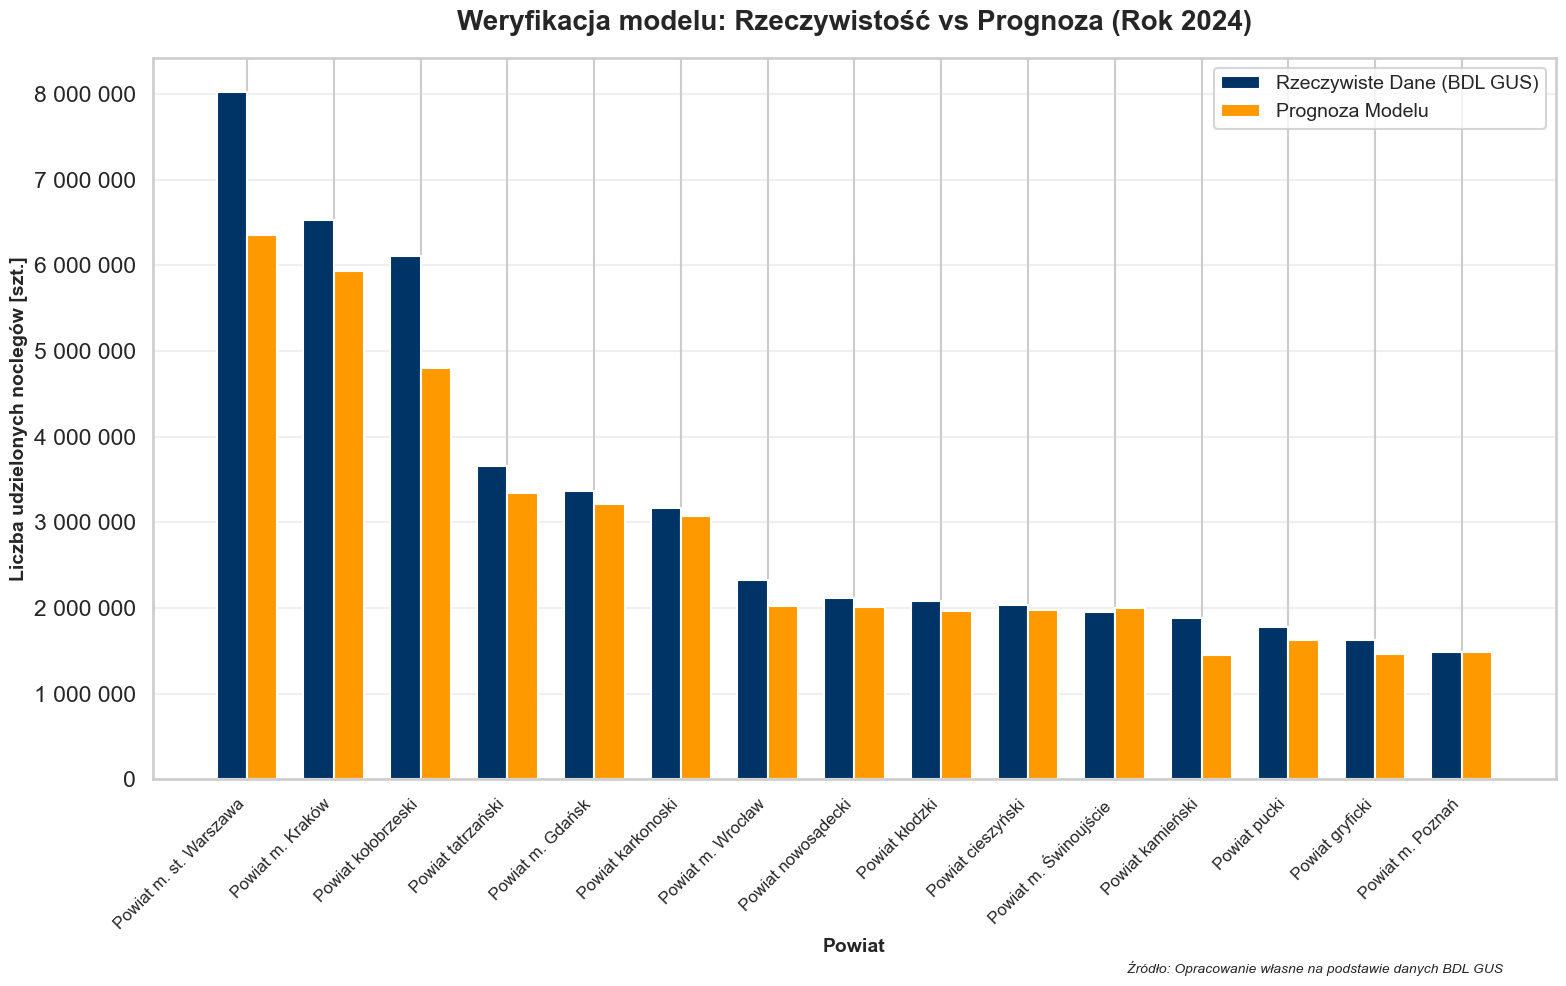

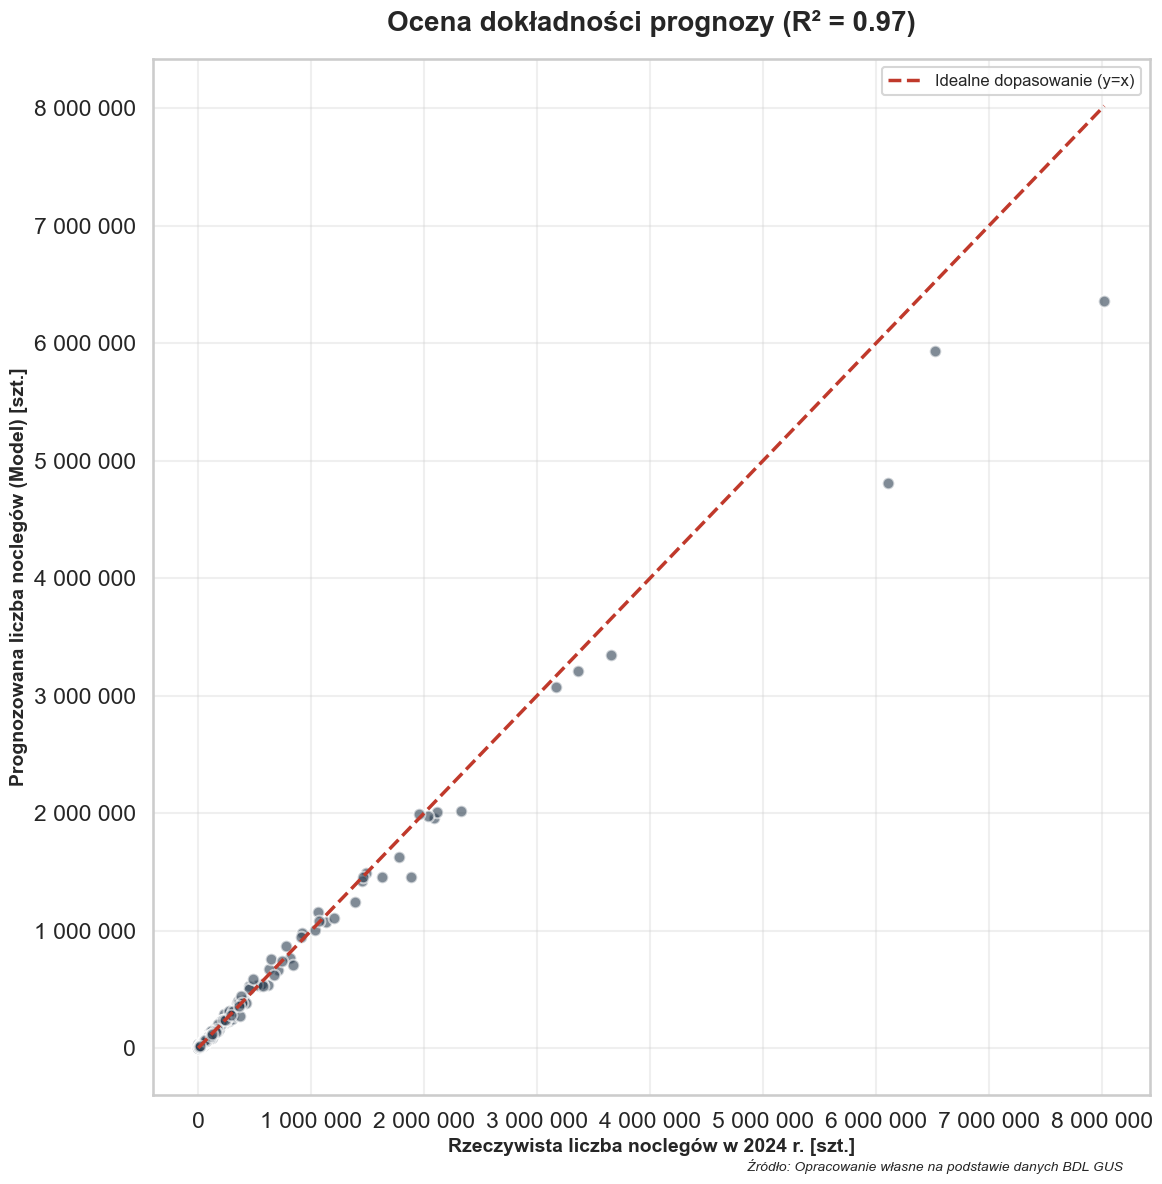

Gotowe. R2: 0.974, MAE: 26429


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import os

# Ustawienia stylu (akademicki)
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'Arial'

# 1. Wczytanie danych
file_name = "master_dataset_project.csv"
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
elif os.path.exists(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv"):
    df = pd.read_csv(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv")
else:
    raise FileNotFoundError("Brak pliku master_dataset_project.csv")

# Czyszczenie
df.columns = df.columns.str.strip()
df['Rok'] = pd.to_numeric(df['Rok'], errors='coerce')
df = df.dropna(subset=['Rok'])
df['Rok'] = df['Rok'].astype(int)

# 2. Feature Engineering
df = df.sort_values(by=['Kod', 'Rok'])
df['Noclegi_LastYear'] = df.groupby('Kod')['Udzielone_Noclegi'].shift(1)
data_model = df.dropna(subset=['Noclegi_LastYear']).copy()

features = ['Rok', 'Liczba_Miejsc', 'Gestosc_Zaludnienia', 'Lesistosc_Proc', 'Noclegi_LastYear']
target = 'Udzielone_Noclegi'

# 3. Podzial: Trening (< 2024) vs Test (2024)
train_data = data_model[data_model['Rok'] < 2024].copy()
test_data = data_model[data_model['Rok'] == 2024].copy()

# Model
model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
model.fit(train_data[features], train_data[target])
predictions = model.predict(test_data[features])

# Wyniki
results = test_data[['Kod', 'Nazwa', target]].copy()
results['Prognoza'] = predictions
mae = mean_absolute_error(results[target], results['Prognoza'])
r2 = r2_score(results[target], results['Prognoza'])

# =========================================================
# WYKRES 1: Słupkowy (Rzeczywistosc vs Prognoza TOP 15)
# =========================================================
top_15 = results.sort_values(by=target, ascending=False).head(15)

plt.figure(figsize=(16, 10))
x = np.arange(len(top_15))
width = 0.35

plt.bar(x - width/2, top_15[target], width, label='Rzeczywiste Dane (BDL GUS)', color='#003366')
plt.bar(x + width/2, top_15['Prognoza'], width, label='Prognoza Modelu', color='#FF9900')

plt.xlabel('Powiat', fontsize=14, fontweight='bold')
plt.ylabel('Liczba udzielonych noclegów [szt.]', fontsize=14, fontweight='bold')
plt.title(f'Weryfikacja modelu: Rzeczywistość vs Prognoza (Rok 2024)', fontsize=20, fontweight='bold', pad=20)
plt.xticks(x, top_15['Nazwa'], rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Formatowanie liczb z odstępami (np. 100 000)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

# Zrodlo danych
plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("Wykres_Porownanie_2024_Pro.png", dpi=300)
plt.show()

# =========================================================
# WYKRES 2: Regresja (Scatter Plot)
# =========================================================
plt.figure(figsize=(12, 12))

# Punkty
plt.scatter(results[target], results['Prognoza'], alpha=0.6, color='#2c3e50', s=70, edgecolor='white')

# Linia idealna
max_val = max(results[target].max(), results['Prognoza'].max())
plt.plot([0, max_val], [0, max_val], '--', color='#c0392b', linewidth=2.5, label='Idealne dopasowanie (y=x)')

# Opisy
plt.title(f"Ocena dokładności prognozy (R² = {r2:.2f})", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Rzeczywista liczba noclegów w 2024 r. [szt.]", fontsize=14, fontweight='bold')
plt.ylabel("Prognozowana liczba noclegów (Model) [szt.]", fontsize=14, fontweight='bold')

# Formatowanie osi
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Zrodlo danych
plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("Wykres_Regresja_2024_Pro.png", dpi=300)
plt.show()

# Zapis tabeli
results.to_csv("Wyniki_Walidacja_2024.csv", index=False, sep=';')
print(f"Gotowe. R2: {r2:.3f}, MAE: {mae:.0f}")

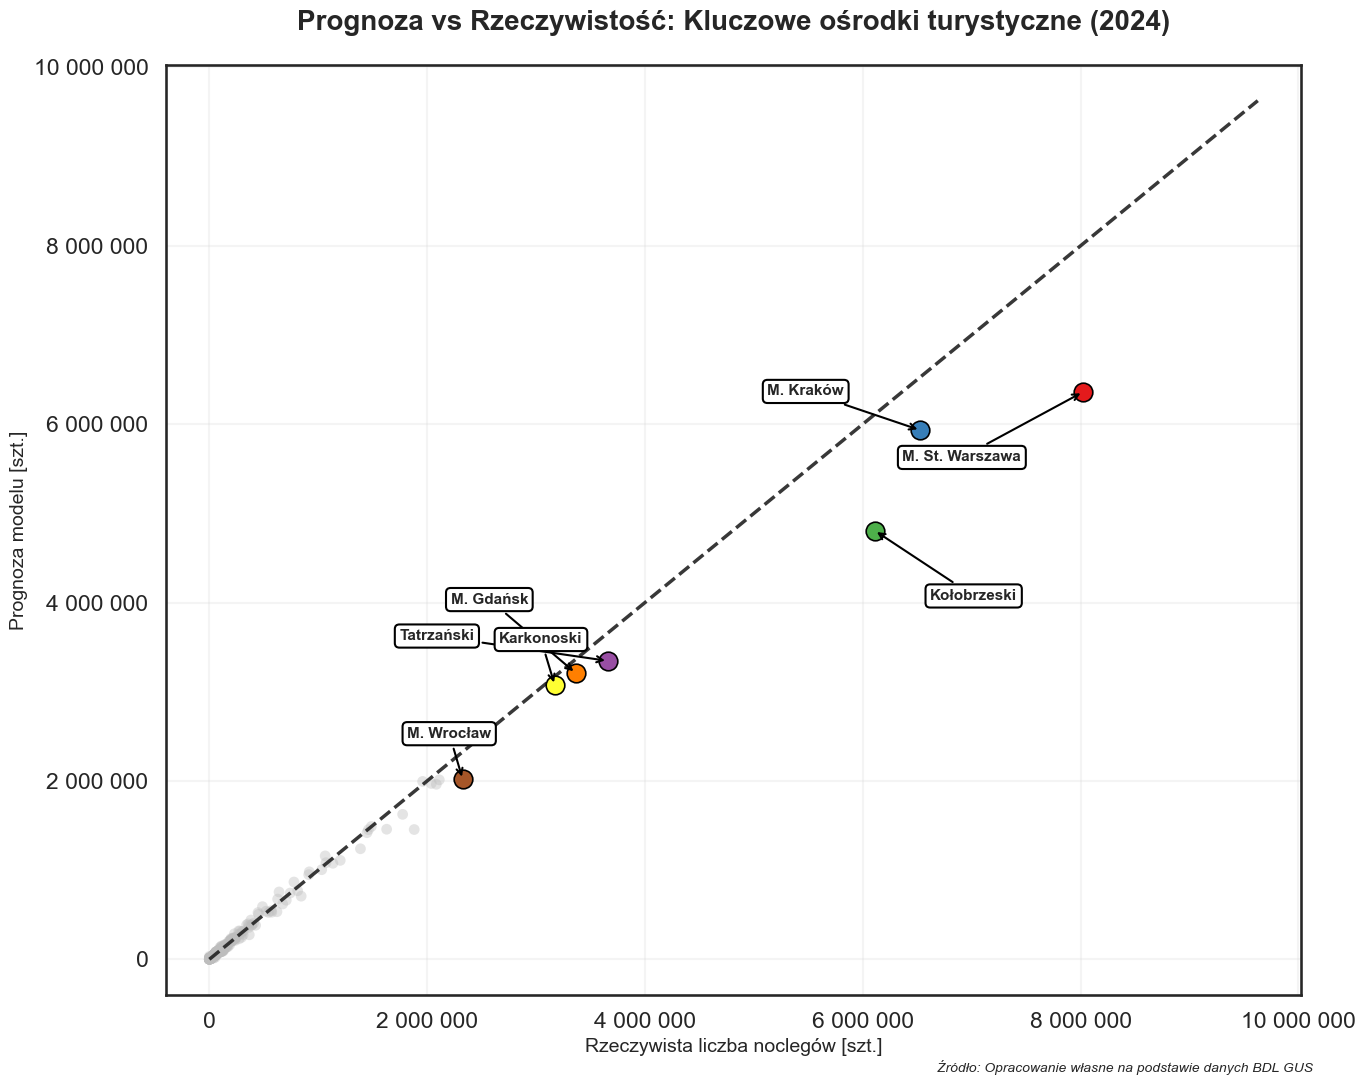

Gotowe. Linie są teraz wyraźne i ciemne.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
import os

# --- USTAWIENIA STYLU ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'Arial'

# 1. WCZYTANIE DANYCH
file_name = "master_dataset_project.csv"
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
elif os.path.exists(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv"):
    df = pd.read_csv(r"C:\Nazar Haievskyj\Dane w\master_dataset_project.csv")
else:
    raise FileNotFoundError("Brak pliku master_dataset_project.csv")

# Czyszczenie
df.columns = df.columns.str.strip()
df['Rok'] = pd.to_numeric(df['Rok'], errors='coerce')
df = df.dropna(subset=['Rok'])
df['Rok'] = df['Rok'].astype(int)
# Skracamy nazwy dla czystości
df['Nazwa'] = df['Nazwa'].str.title().str.replace("Powiat ", "")

# 2. MODELOWANIE
df = df.sort_values(by=['Kod', 'Rok'])
df['Noclegi_LastYear'] = df.groupby('Kod')['Udzielone_Noclegi'].shift(1)
data_model = df.dropna(subset=['Noclegi_LastYear']).copy()

features = ['Rok', 'Liczba_Miejsc', 'Gestosc_Zaludnienia', 'Lesistosc_Proc', 'Noclegi_LastYear']
target = 'Udzielone_Noclegi'

train_data = data_model[data_model['Rok'] < 2024].copy()
test_data = data_model[data_model['Rok'] == 2024].copy()

model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
model.fit(train_data[features], train_data[target])
predictions = model.predict(test_data[features])

results = test_data[['Nazwa', target]].copy()
results['Prognoza'] = predictions

# =========================================================
# TWORZENIE CZYSTEGO WYKRESU (CIEMNE LINIE)
# =========================================================

plt.figure(figsize=(14, 11))

# 1. Tło (Szare punkty)
plt.scatter(
    results[target], 
    results['Prognoza'], 
    color='#bdbdbd', 
    s=60, 
    alpha=0.4, 
    edgecolors='none',
    label='Pozostałe powiaty'
)

# 2. Wybieramy TOP 7
top_points = results.sort_values(by=target, ascending=False).head(7)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

max_val = max(results[target].max(), results['Prognoza'].max())

# Rysowanie punktów i napisów
for i, (index, row) in enumerate(top_points.iterrows()):
    # Punkt
    plt.scatter(
        row[target], 
        row['Prognoza'], 
        color=colors[i], 
        s=180, 
        edgecolors='black',
        linewidth=1.2,
        zorder=10
    )
    
    # Pozycjonowanie napisów
    name = row['Nazwa']
    xytext_pos = (-40, 30) # Domyślne
    
    # Korekty pozycji (żeby nie nachodziły)
    if "Warszawa" in name:
        xytext_pos = (-130, -50)
    elif "Kraków" in name:
        xytext_pos = (-110, 25)
    elif "Tatrzański" in name:
        xytext_pos = (-150, 15)
    elif "Kołobrzeski" in name:
        xytext_pos = (40, -50)
    elif "Gdańsk" in name:
        xytext_pos = (-90, 50)
    elif "Jeleniogórski" in name: # Czasem wchodzi do topki
        xytext_pos = (-100, -30)
        
    # STRZAŁKA (LINIA) - TERAZ CIEMNA I WYRAŹNA
    plt.annotate(
        name, 
        xy=(row[target], row['Prognoza']), 
        xytext=xytext_pos,
        textcoords='offset points',
        # Ustawienia strzałki: czarna (black), pełna (alpha=1), grubsza (linewidth=1.5)
        arrowprops=dict(
            facecolor='black', 
            edgecolor='black',
            arrowstyle="->", 
            linewidth=1.5,
            alpha=1.0  # Pełna widoczność
        ),
        fontsize=11,
        fontweight='bold',
        # Ramka tekstu
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=1.0),
        zorder=20
    )

# 3. Linia idealna (y=x)
plt.plot([0, max_val * 1.2], [0, max_val * 1.2], '--', color='#222222', linewidth=2.5, alpha=0.9, label='Idealne dopasowanie (y=x)')

# Limity osi
plt.xlim(-max_val * 0.05, max_val * 1.25)
plt.ylim(-max_val * 0.05, max_val * 1.25)

# 4. Opisy
plt.title("Prognoza vs Rzeczywistość: Kluczowe ośrodki turystyczne (2024)", fontsize=20, fontweight='bold', pad=25)
plt.xlabel("Rzeczywista liczba noclegów [szt.]", fontsize=14)
plt.ylabel("Prognoza modelu [szt.]", fontsize=14)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

plt.grid(True, alpha=0.2)
plt.figtext(0.95, 0.01, "Źródło: Opracowanie własne na podstawie danych BDL GUS", ha="right", fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("Wykres_Scatter_DarkArrows.png", dpi=300)
plt.show()

print("Gotowe. Linie są teraz wyraźne i ciemne.")